In [169]:
# import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# for regression:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor


In [170]:
# load data
force_plate = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/full_sig/force_plate.csv")
poi_metrics = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/poi/poi_metrics.csv")
hittrax = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/poi/hittrax.csv")
meta = pd.read_csv("/Users/leofeingold/Documents/GitHub/openbiomechanics/baseball_hitting/data/metadata.csv") 

In [171]:
# calculate driveline smash factor to use as target for regression
hittrax_poi = poi_metrics.merge(hittrax[['session_swing', 'pitch']], on='session_swing')
print(f"poi_metrics length: {len(poi_metrics)}")
print(f"hittrax length: {len(hittrax)}")
print(f"hittrax_poi length: {len(hittrax_poi)}")


poi_swings = poi_metrics.session_swing.tolist()
hit_swings = hittrax.session_swing.tolist()

missing_sessions = [session for session in poi_swings if session not in hit_swings]

# Print the missing sessions
print(f"Missing session_swing values in hittrax: {missing_sessions}")



#smash factor calculation
hittrax_poi['smash_factor'] = 1 + ((hittrax_poi['exit_velo_mph_x'] - hittrax_poi['bat_speed_mph_contact_x']) /
                                   (hittrax_poi['pitch'] + hittrax_poi['bat_speed_mph_contact_x']))

poi_metrics length: 677
hittrax length: 604
hittrax_poi length: 604
Missing session_swing values in hittrax: ['111_1', '111_2', '111_3', '111_4', '111_5', '111_6', '111_7', '111_8', '121_1', '121_2', '121_3', '121_4', '121_5', '121_6', '121_7', '121_8', '167_1', '181_1', '181_2', '181_3', '181_4', '181_5', '181_6', '181_7', '181_8', '21_1', '21_2', '21_3', '21_4', '21_5', '23_1', '23_2', '23_3', '23_4', '23_5', '236_1', '236_2', '236_3', '236_4', '265_1', '265_2', '265_3', '265_4', '265_5', '265_6', '265_7', '265_8', '302_1', '302_2', '302_3', '302_4', '302_5', '302_6', '302_7', '302_8', '504_1', '504_2', '504_3', '504_4', '504_5', '504_6', '504_7', '504_8', '6_1', '6_2', '6_3', '6_4', '6_5', '8_1', '8_2', '8_3', '8_4', '8_5']


In [172]:
mechanical_poi_columns = [
    'bat_torso_angle_connection_x',
    'attack_angle_contact_x',
    'bat_torso_angle_ds_y',
    'hand_speed_blast_bat_mph_max_x',
    'hand_speed_mag_max_x',
    'pelvis_angle_fm_x',
    'pelvis_angle_fm_y',
    'pelvis_angle_fm_z',
    'pelvis_angle_fp_x', 
    'pelvis_angle_fp_y', 
    'pelvis_angle_fp_z',
    'pelvis_angle_hs_x', 
    'pelvis_angle_hs_y', 
    'pelvis_angle_hs_z',
    'torso_angle_fm_x', 
    'torso_angle_fm_y', 
    'torso_angle_fm_z',
    'torso_angle_fp_x', 
    'torso_angle_fp_y', 
    'torso_angle_fp_z',
    'torso_angle_hs_x', 
    'torso_angle_hs_y', 
    'torso_angle_hs_z',
    'upper_arm_speed_mag_max_x',
    'x_factor_fm_x', 
    'x_factor_fm_y', 
    'x_factor_fm_z',
    'x_factor_fp_x', 
    'x_factor_fp_y', 
    'x_factor_fp_z',
    'pelvis_angular_velocity_fm_x',
    'pelvis_angular_velocity_fp_x',
    'pelvis_angular_velocity_maxhss_x',
    'pelvis_angular_velocity_seq_max_x',
    'pelvis_angular_velocity_stride_max_x',
    'pelvis_angular_velocity_swing_max_x',
    'rear_elbow_fm_x', 
    'rear_elbow_fm_z',
    'rear_elbow_launchpos_x',
    'rear_elbow_stride_max_x', 
    'rear_elbow_stride_max_z',
    'rear_elbow_swing_max_x', 
    'rear_elbow_swing_max_z',
    'rear_hip_launchpos_x',
    'rear_hip_stride_max_x', 
    'rear_hip_stride_max_y', 
    'rear_hip_stride_max_z',
    'rear_shoulder_launchpos_x',
    'rear_shoulder_stride_max_x', 
    'rear_shoulder_stride_max_y', 
    'rear_shoulder_stride_max_z',
    'torso_angular_velocity_fm_x',
    'torso_angular_velocity_fp_x',
    'torso_angular_velocity_maxhss_x',
    'torso_angular_velocity_seq_max_x',
    'torso_angular_velocity_stride_max_x',
    'torso_angular_velocity_swing_max_x',
    'upper_arm_speed_mag_fm_x',
    'upper_arm_speed_mag_fp_x',
    'upper_arm_speed_mag_maxhss_x',
    'upper_arm_speed_mag_seq_max_x',
    'upper_arm_speed_mag_stride_max_velo_x',
    'upper_arm_speed_mag_swing_max_velo_x',
    'x_factor_hs_x', 
    'x_factor_hs_y', 
    'x_factor_hs_z',
    'max_cog_velo_x',
]

# potential target variables:
'''
'smash_factor',
'exit_velo_mph_x'
'bat_speed_mph_max_x'
'''



"\n'smash_factor',\n'exit_velo_mph_x'\n'bat_speed_mph_max_x'\n"

In [173]:
# select columns and split data into training and testing
X = hittrax_poi[mechanical_poi_columns]
y = hittrax_poi["smash_factor"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
# scale values for better regression results I believe mean=0, std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [175]:
'''
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 200],
    'alpha': [0, 1, 10],
    'lambda': [0, 1, 10]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with best parameters
bst = xgb.XGBRegressor(**best_params)
bst.fit(X_train_scaled, y_train)

# Make predictions
y_pred = bst.predict(X_test_scaled)

******
# Best parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0.1, 'lambda': 10, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
******
'''

'\n# Define parameter grid\nparam_grid = {\n    \'max_depth\': [3, 5, 7],\n    \'eta\': [0.01, 0.1, 0.3],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'n_estimators\': [50, 100, 200],\n    \'alpha\': [0, 1, 10],\n    \'lambda\': [0, 1, 10]\n}\n\n# Initialize XGBoost model\nxgb_model = xgb.XGBRegressor(objective=\'reg:squarederror\')\n\n# Initialize Grid Search\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring=\'neg_mean_squared_error\', verbose=3)\n\n# Fit Grid Search\ngrid_search.fit(X_train_scaled, y_train)\n\n# Best parameters\nbest_params = grid_search.best_params_\nprint(f"Best parameters: {best_params}")\n\n# Train the model with best parameters\nbst = xgb.XGBRegressor(**best_params)\nbst.fit(X_train_scaled, y_train)\n\n# Make predictions\ny_pred = bst.predict(X_test_scaled)\n\n******\n# Best parameters: {\'alpha\': 0, \'colsample_bytree\': 0.8, \'eta\': 0.1, \'lambda\': 10, \'max_depth\': 5, \'n_estima

In [176]:
# convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = {
    'objective': 'reg:squarederror',  # for regression task
    'max_depth': 5,  # maximum depth of a tree
    'eta': 0.1,  # learning rate
    'subsample': 0.8,  # subsample ratio of the training instances
    'colsample_bytree': 0.8,  # subsample ratio of columns when constructing each tree
    'alpha': 0,  # L1 regularization term
    'lambda': 10,  # L2 regularization term
}

# Number of boosting rounds
num_boost_round = 50

# Train the model with the corrected parameters
bst_corrected = xgb.train(params, dtrain, num_boost_round)

# Make predictions
y_pred_corrected = bst_corrected.predict(dtest)



MSE: 0.003262660640042623
MAE: 0.037405606917109924
R2 Score: 0.02870499028488982
count    604.000000
mean       1.201846
std        0.063436
min        0.932570
25%        1.174435
50%        1.197427
75%        1.224178
max        1.512828
Name: smash_factor, dtype: float64
                                  feature  importance
0            bat_torso_angle_connection_x        65.0
1                  attack_angle_contact_x        57.0
3          hand_speed_blast_bat_mph_max_x        40.0
4                    hand_speed_mag_max_x        40.0
23              upper_arm_speed_mag_max_x        38.0
6                       pelvis_angle_fm_y        35.0
37                        rear_elbow_fm_z        34.0
29                          x_factor_fp_z        34.0
5                       pelvis_angle_fm_x        31.0
38                 rear_elbow_launchpos_x        28.0
8                       pelvis_angle_fp_x        27.0
7                       pelvis_angle_fm_z        26.0
57               uppe

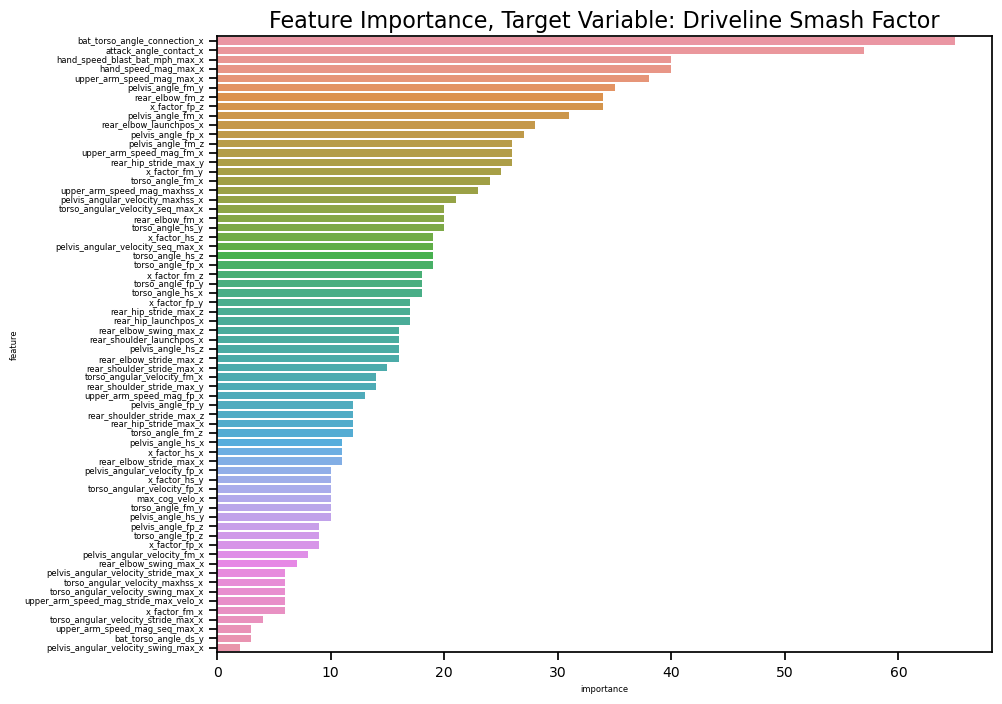

In [177]:
# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')
print(hittrax_poi["smash_factor"].describe())

# determine feature importance
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'feature': [mechanical_poi_columns[int(k[1:])] for k in importance.keys()],
    'importance': importance.values()
}).sort_values(by='importance', ascending=False)
print(importance_df)



plt.figure(figsize=(10, 8))
sns.set_context("notebook", rc={"axes.titlesize":14, "axes.labelsize":6, "xtick.labelsize":10, "ytick.labelsize":6})
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance, Target Variable: Driveline Smash Factor', fontsize=16)
plt.show()